In [25]:
!which python

/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/bin/python


In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR,LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [4]:
df = pd.read_pickle('../dataset/preprocessed/284_imputed.pkl')

print(df.isna().sum())

print(df.dtypes)

DOA              0
LeadTime         0
DOW              0
Price            0
TotalCapacity    0
Reservations     0
dtype: int64
DOA              datetime64[ns]
LeadTime                  int64
DOW                       int64
Price                   float64
TotalCapacity           float64
Reservations            float64
dtype: object


In [3]:
# df = df[df['LeadTime']==89]
df = df.rename(columns={'Reservations':'ROH'})

# SVR
- https://stats.stackexchange.com/questions/82044/how-does-support-vector-regression-work-intuitively
- https://stats.stackexchange.com/questions/13194/support-vector-machines-and-regression

In [30]:
df.head()

,DOA,LeadTime,DOW,Price,TotalCapacity,ROH
0,2018-01-01,88,0,76.05,290.0,58.0
1,2018-01-01,87,0,76.05,290.0,58.0
2,2018-01-01,85,0,76.05,290.0,58.0
3,2018-01-01,81,0,76.05,290.0,63.0
4,2018-01-01,80,0,76.05,290.0,62.0


In [31]:
df.loc[df['Price'] > 154, 'Price'] = df['Price'].median()

In [32]:
df.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
DOA,60387,719,2019-02-04,90,2018-01-01,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LeadTime,60387,NaN,NaT,NaN,NaT,NaT,43.568,26.0125,0,21,43,66,89
DOW,60387,NaN,NaT,NaN,NaT,NaT,2.99985,2.00307,0,1,3,5,6
Price,60387,NaN,NaT,NaN,NaT,NaT,72.33,25.0373,30.24,53.82,67.16,82.73,154
TotalCapacity,60387,NaN,NaT,NaN,NaT,NaT,290,0,290,290,290,290,290
ROH,60387,NaN,NaT,NaN,NaT,NaT,129.446,71.5171,0,72,119,181,290


In [35]:
dx = df[df['LeadTime']==89]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dx.DOA, y=dx.Price,mode='markers+lines',name='ROH'))
fig.update_layout(autosize=False,width=1000,height=300,xaxis_title="Reservations on Hand (ROH)",yaxis_title="Day of Arrival (DOA)")
fig.show()   

## Train Test split 

In [8]:
# This is a hack to combine both datetime columns
from datetime import timedelta ,datetime
df['DOA'] = df['DOA']+df['LeadTime'].apply(lambda x: timedelta(minutes=(1440-((x+1)*16)))) 

timestamp_s = df['DOA'].map(datetime.timestamp)

In [9]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

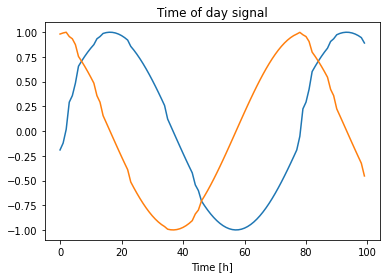

In [10]:
plt.plot(np.array(df['Day sin'])[:100])
plt.plot(np.array(df['Day cos'])[:100])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [11]:
df = df.set_index('DOA')   

In [12]:
df = df.drop(columns='TotalCapacity')

In [13]:
scaler = StandardScaler()
df[['LeadTime','DOW','Price','ROH']] = scaler.fit_transform(df[['LeadTime','DOW','Price','ROH']])

In [14]:
df

,LeadTime,DOW,Price,ROH,Day sin,Day cos,Year sin,Year cos
DOA,,,,,,,,
2018-01-01 00:16:00,1.708113,-1.497636,0.148578,-0.999021,-0.190809,0.981627,0.005667,0.999984
2018-01-01 00:32:00,1.669669,-1.497636,0.148578,-0.999021,-0.121869,0.992546,0.005858,0.999983
2018-01-01 01:04:00,1.592783,-1.497636,0.148578,-0.999021,0.017452,0.999848,0.006241,0.999981
2018-01-01 02:08:00,1.439010,-1.497636,0.148578,-0.929107,0.292372,0.956305,0.007005,0.999975
2018-01-01 02:24:00,1.400566,-1.497636,0.148578,-0.943090,0.358368,0.933580,0.007196,0.999974
...,...,...,...,...,...,...,...,...
2019-12-31 22:40:00,-1.521126,-0.998399,-0.206494,1.979313,-0.573576,0.819152,-0.003823,0.999993
2019-12-31 22:56:00,-1.559569,-0.998399,-0.206494,2.133123,-0.515038,0.857167,-0.003632,0.999993
2019-12-31 23:12:00,-1.598013,-0.998399,-0.206494,2.091175,-0.453990,0.891007,-0.003441,0.999994


In [15]:
train     = df.loc[:'2019-10']
test      = df.loc['2019-10':]

In [16]:
y = train.pop('ROH')
X = train

In [17]:
svm_reg = LinearSVR(epsilon=1.5)
model_reg = svm_reg.fit(X, y)
test['svm_reg'] = svm_reg.predict(test.loc[:, test.columns != 'ROH']) 

In [20]:
svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
model_rbf = svr_rbf.fit(X, y)
test['svm_rbf'] = model_rbf.predict(test[['LeadTime','DOW','Price','Day sin','Day cos','Year sin','Year cos']]) 

In [36]:
dx = test[test['LeadTime']==test['LeadTime'].max()]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dx.index, y=dx['ROH'],mode='markers+lines',name='True'))
fig.add_trace(go.Scatter(x=dx.index, y=dx['svm_reg'],mode='markers+lines',name='svm_reg'))
fig.add_trace(go.Scatter(x=dx.index, y=dx['svm_rbf'],mode='markers+lines',name='svm_rbf'))

fig.update_layout(autosize=False,width=1000,height=400,xaxis_title="Reservations on Hand (ROH)",yaxis_title="Day of Arrival (DOA)")
fig.show()   

In [25]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

mse = mean_squared_error(test['ROH'], test['svm_reg'])
mae = mean_absolute_error(test['ROH'], test['svm_reg'])
r2  = r2_score(test['ROH'], test['svm_reg'])

print('SVM Reg MSE: %0.3f MAE: %0.3f R2: %03f'%(mse,mae,r2))

mse = mean_squared_error(test['ROH'], test['svm_rbf'])
mae = mean_absolute_error(test['ROH'], test['svm_rbf'])
r2  = r2_score(test['ROH'], test['svm_rbf'])

print('SVM Rbf MSE: %0.3f MAE: %0.3f R2: %03f'%(mse,mae,r2))

SVM Reg MSE: 0.349 MAE: 0.498 R2: 0.678379
SVM Rbf MSE: 0.202 MAE: 0.338 R2: 0.813855


In [13]:
from sklearn.model_selection import cross_validate

scoring = {'r2':'r2', 'MSE':'neg_mean_squared_error'}
for degree in range(2,7):
    res = cross_validate(polynomialRegression(degree), X, y, cv=270,scoring=scoring, return_train_score=True)
    
    print("Poly degree:",degree)
    print("R2  Test Score: %0.2f (+/- %0.2f)) | Train Score: %0.2f (+/- %0.2f))"%(res['test_r2'].mean(),res['test_r2'].std()* 2,res['train_r2'].mean(),res['train_r2'].std()* 2))
    print("MSE Test Score: %0.2f (+/- %0.2f)) | Train Score: %0.2f (+/- %0.2f))"%(res['test_MSE'].mean(),res['test_MSE'].std()* 2,res['train_MSE'].mean(),res['train_MSE'].std()* 2))
    print("RMSE Test Score: %0.2f (+/- %0.2f)) | Train Score: %0.2f (+/- %0.2f))"%(np.sqrt(-res['test_MSE']).mean(),np.sqrt(-res['test_MSE']).std()* 2,np.sqrt(-res['train_MSE']).mean(),np.sqrt(-res['test_MSE']).std()* 2))

0.3561481123378775

# With ROH

In [5]:
df = pd.read_pickle('../dataset/preprocessed/284_imputed.pkl')

In [6]:
df.head()

,DOA,LeadTime,DOW,Price,TotalCapacity,Reservations
0,2018-01-01,88,0,76.05,290.0,58.0
1,2018-01-01,87,0,76.05,290.0,58.0
2,2018-01-01,85,0,76.05,290.0,58.0
3,2018-01-01,81,0,76.05,290.0,63.0
4,2018-01-01,80,0,76.05,290.0,62.0


In [7]:
df = df.rename(columns={'Reservations':'ROH'})
scaler = StandardScaler()
df[['DOW','Price','ROH']] = scaler.fit_transform(df[['DOW','Price','ROH']])
df = df.pivot(index='DOA',columns='LeadTime',values='ROH')
df = df.bfill(axis=1).ffill(axis=1)

In [8]:
# df = df.drop(columns=[1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,19,21])
cols = df.columns[df.columns.isin([89,79,69,59,49,39,29,19,9,0])]
df = df[cols]

In [9]:
df['DOW'] = df.index.dayofweek

In [10]:
train     = df.loc[:'2019-10']
test      = df.loc['2019-10':]

In [11]:
y = train.pop(0)
X = train

In [12]:
svm_reg = LinearSVR(epsilon=0.5)
model_reg = svm_reg.fit(X, y)
test_svm_reg = svm_reg.predict(test.loc[:, test.columns != 0]) 

In [13]:
svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
model_rbf = svr_rbf.fit(X, y)
test_svm_rbf = model_rbf.predict(test.loc[:, test.columns != 0]) 

In [14]:
test.loc[:, test.columns != 0]

LeadTime,9,19,29,39,49,59,69,79,89,DOW
DOA,,,,,,,,,,
2019-10-01,0.609000,0.189516,0.021723,-0.257933,-0.411744,-0.523606,-0.705382,-0.761313,-0.775296,1
2019-10-02,0.567051,0.231464,-0.048191,-0.775296,-0.929107,-1.040969,-1.110883,-1.124866,-1.138849,2
2019-10-03,1.056449,0.413241,0.077654,-0.635468,-0.789279,-0.971055,-1.096900,-1.110883,-1.110883,3
2019-10-04,1.615760,0.581034,0.119602,-0.747331,-0.859193,-1.040969,-1.138849,-1.152831,-1.180797,4
2019-10-05,1.420001,0.455189,-0.006243,-0.845210,-1.040969,-1.250711,-1.362573,-1.390539,-1.432487,5
...,...,...,...,...,...,...,...,...,...,...
2019-12-27,1.895416,0.818741,-0.132088,-0.160054,-0.411744,-0.649451,-0.873176,-1.054952,-1.180797,4
2019-12-28,2.147106,1.112380,0.553069,0.161551,-0.215985,-0.453692,-0.747331,-0.915124,-1.068935,5
2019-12-29,1.406018,0.874673,0.371292,0.077654,-0.243950,-0.397761,-0.565554,-0.747331,-0.901141,6


In [15]:
test['svm_reg'] = test_svm_reg
test['svm_rbf'] = test_svm_rbf
test.head()

LeadTime,0,9,19,29,39,49,59,69,79,89,DOW,svm_reg,svm_rbf
DOA,,,,,,,,,,,,,
2019-10-01,1.881433,0.609000,0.189516,0.021723,-0.257933,-0.411744,-0.523606,-0.705382,-0.761313,-0.775296,1,1.660012,1.908995
2019-10-02,1.629743,0.567051,0.231464,-0.048191,-0.775296,-0.929107,-1.040969,-1.110883,-1.124866,-1.138849,2,1.607630,1.807769
2019-10-03,1.909399,1.056449,0.413241,0.077654,-0.635468,-0.789279,-0.971055,-1.096900,-1.110883,-1.110883,3,1.708012,2.007353
2019-10-04,2.063209,1.615760,0.581034,0.119602,-0.747331,-0.859193,-1.040969,-1.138849,-1.152831,-1.180797,4,1.830741,2.064731
2019-10-05,2.147106,1.420001,0.455189,-0.006243,-0.845210,-1.040969,-1.250711,-1.362573,-1.390539,-1.432487,5,1.724561,2.047110


In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test[0],mode='markers+lines',name='True'))
fig.add_trace(go.Scatter(x=test.index, y=test['svm_reg'],mode='markers+lines',name='svm_reg'))
fig.add_trace(go.Scatter(x=test.index, y=test['svm_rbf'],mode='markers+lines',name='svm_rbf'))

fig.update_layout(autosize=False,width=1000,height=400,xaxis_title="Reservations on Hand (ROH)",yaxis_title="Day of Arrival (DOA)")
fig.show()   

In [23]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae  = np.mean(np.abs(forecast - actual))    # MAE
    mpe  = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':round(mape,3), 'mae':round(mae,3) , 'mpe':round(mpe,3) , 'rmse':round(rmse,3)})

In [24]:
print("SVM Regression ",forecast_accuracy(test['svm_reg'],test[0]))
print("SVM Radial     ",forecast_accuracy(test['svm_rbf'],test[0]))

SVM Regression  {'mape': 0.296, 'mae': 0.242, 'mpe': 0.183, 'rmse': 0.338}
SVM Radial      {'mape': 0.284, 'mae': 0.207, 'mpe': 0.252, 'rmse': 0.332}
